In [1]:
pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
import ast
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib
import json
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

# Load data
df_train = pd.read_csv("../codebert/train_data.csv")
df_test = pd.read_csv("../codebert/test_data.csv")
X_train = torch.load("../codebert/X_train.pt", weights_only=False).to(device)
X_test = torch.load("../codebert/X_test.pt", weights_only=False).to(device)

def process_vulnerability_list(vuln_list_series, num_classes=9):
    vuln_lists = vuln_list_series.apply(ast.literal_eval)
    y_binary = np.array([np.array(vuln) for vuln in vuln_lists], dtype=np.float32)
    if y_binary.shape[1] != num_classes:
        raise ValueError(f"Expected {num_classes} dimensions, got {y_binary.shape[1]}")
    return torch.tensor(y_binary, dtype=torch.float32)

y_train = process_vulnerability_list(df_train['vulnerability_list'], num_classes=9).to(device)
y_test = process_vulnerability_list(df_test['vulnerability_list'], num_classes=9).to(device)
torch.save(y_train, "../codebert/y_train.pt")
torch.save(y_test, "../codebert/y_test.pt")

# 驗證形狀
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Training on device: mps
X_train shape: torch.Size([4294, 768])
y_train shape: torch.Size([4294, 9])
X_test shape: torch.Size([1074, 768])
y_test shape: torch.Size([1074, 9])


In [3]:
class VulnScreener(nn.Module):
    def __init__(self):
        super(VulnScreener, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(768, 256),  # Input layer to Hidden Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),  # Hidden Layer 1 to Hidden Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),    # Hidden Layer 2 to Output Layer
            nn.Sigmoid()          # Probability output
        )
    
    def forward(self, x):
        return self.mlp(x)  # Forward pass through the network

# Load screener probabilities
screener = torch.load("../codebert/vuln_screener_model.pth", weights_only=False, map_location=device)
screener.eval()
with torch.no_grad():
    train_prob = screener(X_train).cpu().numpy()  # Move to CPU for XGBoost compatibility
    test_prob = screener(X_test).cpu().numpy()

# Combine embeddings with probabilities (on CPU for XGBoost)
X_train_combined = np.hstack([X_train.cpu().numpy(), train_prob])
X_test_combined = np.hstack([X_test.cpu().numpy(), test_prob])

In [4]:
# Define target classes to improve
target_classes = [2, 3, 5, 7]
n_classes = y_train.shape[1]

# Determine the maximum number of samples needed after balancing
original_samples = X_train_combined.shape[0]
class_counts = [int(sum(y_train[:, i].cpu().numpy())) for i in range(n_classes)]
max_samples = max_samples = max(class_counts)  # Balance to majority class

print(f"Original samples: {original_samples}")
print(f"Class counts: {class_counts}")
print(f"Max samples for balancing: {max_samples}")

# Handle class imbalance with SMOTE for all classes
X_train_resampled = None
y_train_resampled = None

for i in range(n_classes):
    # Stronger oversampling for 2 and 3
    if i in [2, 3]:
        smote = SMOTE(sampling_strategy={1: 1000}, random_state=42)
    else:
        smote = SMOTE(sampling_strategy={1: max_samples}, random_state=42)
    X_res, y_res = smote.fit_resample(X_train_combined, y_train[:, i].cpu().numpy())
    if i == 0:
        X_train_resampled = X_res[:max_samples]
        y_train_resampled = np.zeros((max_samples, n_classes))
    y_train_resampled[:, i] = y_res[:max_samples]

# Verify shapes
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

Original samples: 4294
Class counts: [2310, 298, 59, 59, 224, 431, 788, 206, 787]
Max samples for balancing: 2310
X_train_resampled shape: (2310, 769)
y_train_resampled shape: (2310, 9)


In [5]:
# Calculate class ratios with emphasis on target classes
class_ratios = [len(y_train_resampled) / (sum(y_train_resampled[:, i]) + 1e-10) for i in range(n_classes)]
# Increase scale_pos_weight for target classes to boost precision
for i in target_classes:
    if i in [2, 3]:
        class_ratios[i] *= 10  # Stronger boost for 2 and 3 due to low precision
    else:
        class_ratios[i] *= 2  # Moderate boost for 5 and 7
    
# XGBoost base classifier
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist' if torch.cuda.is_available() else 'auto',
    device='cuda' if torch.cuda.is_available() else None,
    max_depth=5,          # Slightly reduced to avoid overfitting
    learning_rate=0.05,   # Lowered for finer updates
    n_estimators=300,     # Increased for better learning
    min_child_weight=3,   # Increased to reduce noise sensitivity
    gamma=0.1,            # Added regularization
    subsample=0.8,        # Reduced to prevent overfitting
    random_state=42
)

# Initialize MultiOutputClassifier with a single base estimator
xgb_model = MultiOutputClassifier(estimator=xgb_base, n_jobs=1)

# Calculate class ratios
class_ratios = [len(y_train_resampled) / (sum(y_train_resampled[:, i]) + 1e-10) for i in range(n_classes)]

# Fit the model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Set scale_pos_weight for each estimator after fitting
for i, est in enumerate(xgb_model.estimators_):
    est.set_params(scale_pos_weight=class_ratios[i])

# Predict probabilities
y_pred_proba = np.array([est.predict_proba(X_test_combined)[:, 1] for est in xgb_model.estimators_]).T

In [6]:
# Compute optimal thresholds maximizing F1-score
optimal_thresholds = []
min_recall = 0.4
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i].cpu().numpy(), y_pred_proba[:, i])
    valid_indices = np.where(recall[:-1] >= min_recall)[0]
    if len(valid_indices) > 0:
        precision_scores = precision[:-1][valid_indices]
        optimal_idx = valid_indices[np.argmax(precision_scores)]
        optimal_threshold = thresholds[optimal_idx]
    else:
        # Relaxed fallback for 2 and 3
        valid_indices = np.where(recall[:-1] >= 0.3)[0] if i in [2, 3] else np.where(recall[:-1] >= min_recall)[0]
        if len(valid_indices) > 0:
            precision_scores = precision[:-1][valid_indices]
            optimal_idx = valid_indices[np.argmax(precision_scores)]
            optimal_threshold = thresholds[optimal_idx]
        else:
            optimal_threshold = 0.5
    # Adjust threshold for target classes
    if i in target_classes:
        if i in [2, 3]:
            optimal_threshold = min(optimal_threshold + 0.3, 0.8)  # Stronger boost for 2 and 3
        else:
            optimal_threshold = min(optimal_threshold + 0.15, 0.75)  # Moderate boost for 5 and 7
    optimal_thresholds.append(optimal_threshold)
    
# Apply thresholds
y_pred_binary = np.zeros_like(y_pred_proba)
for i in range(n_classes):
    y_pred_binary[:, i] = (y_pred_proba[:, i] >= optimal_thresholds[i]).astype(int)

In [7]:
# Convert y_test to NumPy array for metrics computation
y_test_np = y_test.cpu().numpy()

# Compute metrics
metrics = {
    'avg_precision': precision_score(y_test_np, y_pred_binary, average='micro'),
    'avg_recall': recall_score(y_test_np, y_pred_binary, average='micro'),
    'avg_f1': f1_score(y_test_np, y_pred_binary, average='micro'),
    'avg_auc': roc_auc_score(y_test_np, y_pred_proba, average='micro'),
    'optimal_thresholds': optimal_thresholds
}

class_metrics = {
    'precision': precision_score(y_test_np, y_pred_binary, average=None),
    'recall': recall_score(y_test_np, y_pred_binary, average=None),
    'f1': f1_score(y_test_np, y_pred_binary, average=None),
    'auc': [roc_auc_score(y_test_np[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
}
metrics['class_metrics'] = class_metrics

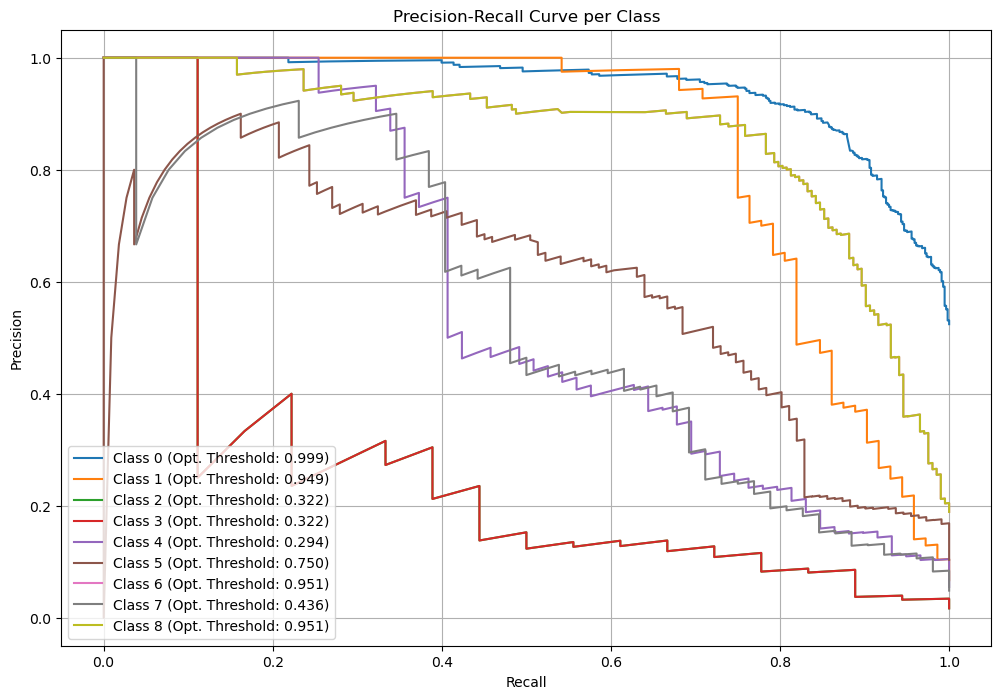

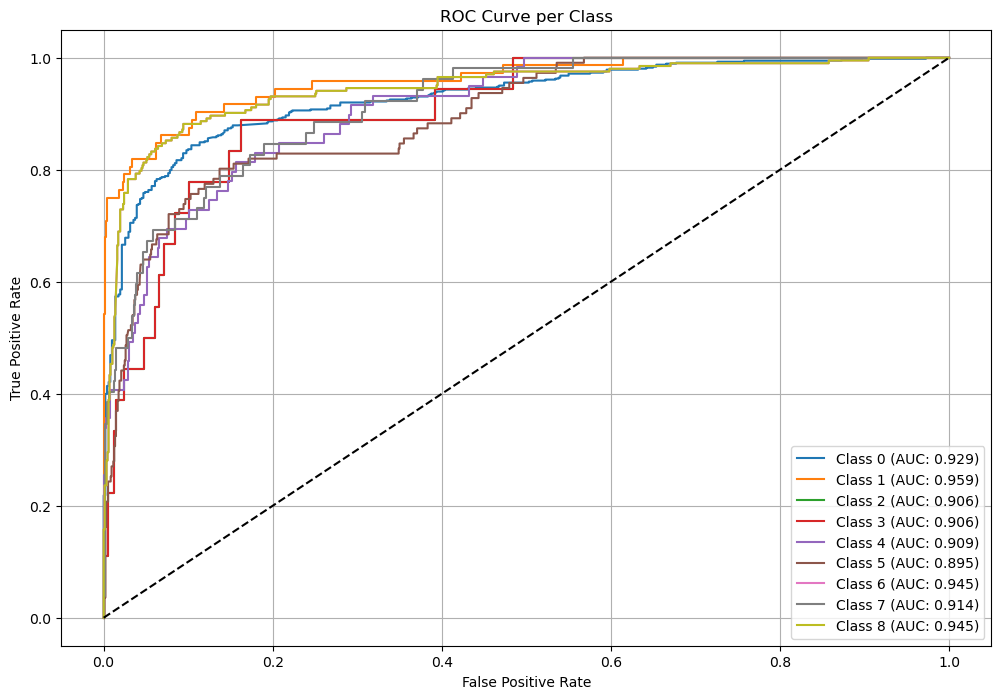

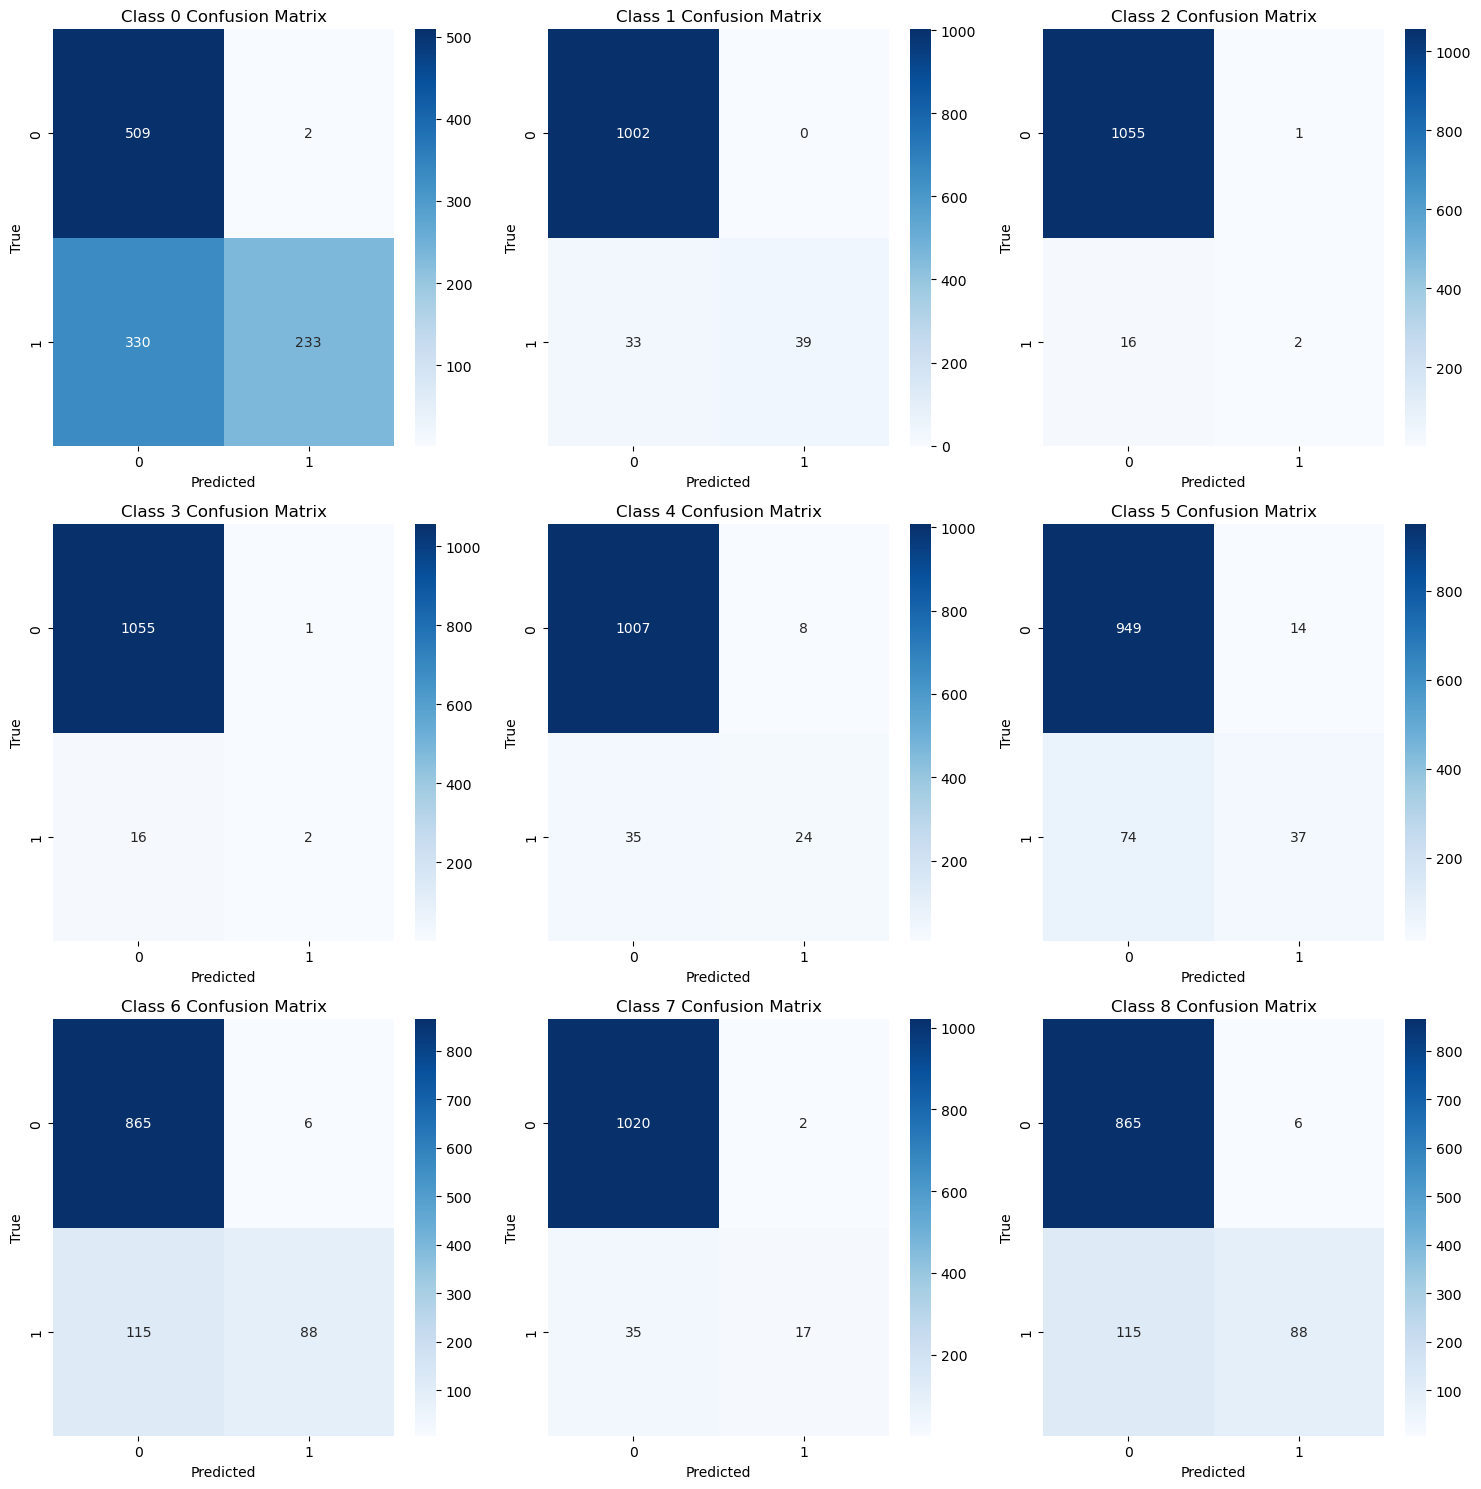


=== XGBoost Test Results (Optimal Thresholds) ===
Test Samples: 1074
Average Precision: 0.9298
Average Recall: 0.4080
Average F1-Score: 0.5671
Average AUC: 0.9471

Per-Class Metrics with Optimal Thresholds:

Vulnerability 0 (Threshold: 0.999):
Precision: 0.9915
Recall: 0.4139
F1-Score: 0.5840
AUC: 0.9292

Vulnerability 1 (Threshold: 0.949):
Precision: 1.0000
Recall: 0.5417
F1-Score: 0.7027
AUC: 0.9591

Vulnerability 2 (Threshold: 0.322):
Precision: 0.6667
Recall: 0.1111
F1-Score: 0.1905
AUC: 0.9060

Vulnerability 3 (Threshold: 0.322):
Precision: 0.6667
Recall: 0.1111
F1-Score: 0.1905
AUC: 0.9060

Vulnerability 4 (Threshold: 0.294):
Precision: 0.7500
Recall: 0.4068
F1-Score: 0.5275
AUC: 0.9086

Vulnerability 5 (Threshold: 0.750):
Precision: 0.7255
Recall: 0.3333
F1-Score: 0.4568
AUC: 0.8951

Vulnerability 6 (Threshold: 0.951):
Precision: 0.9362
Recall: 0.4335
F1-Score: 0.5926
AUC: 0.9447

Vulnerability 7 (Threshold: 0.436):
Precision: 0.8947
Recall: 0.3269
F1-Score: 0.4789
AUC: 0.9142


In [8]:
# Plot Precision-Recall Curves
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_np[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (Opt. Threshold: {optimal_thresholds[i]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curves
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_np[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_np[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC: {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend()
plt.grid(True)
plt.show()

# Plot Confusion Matrices
plt.figure(figsize=(15, 15))
for i in range(n_classes):
    cm = confusion_matrix(y_test_np[:, i], y_pred_binary[:, i])
    plt.subplot(3, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Class {i} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

# Print results
print("\n=== XGBoost Test Results (Optimal Thresholds) ===")
print(f"Test Samples: {len(X_test)}")
print(f"Average Precision: {metrics['avg_precision']:.4f}")
print(f"Average Recall: {metrics['avg_recall']:.4f}")
print(f"Average F1-Score: {metrics['avg_f1']:.4f}")
print(f"Average AUC: {metrics['avg_auc']:.4f}")

print("\nPer-Class Metrics with Optimal Thresholds:")
for i in range(n_classes):
    print(f"\nVulnerability {i} (Threshold: {optimal_thresholds[i]:.3f}):")
    print(f"Precision: {class_metrics['precision'][i]:.4f}")
    print(f"Recall: {class_metrics['recall'][i]:.4f}")
    print(f"F1-Score: {class_metrics['f1'][i]:.4f}")
    print(f"AUC: {class_metrics['auc'][i]:.4f}")

In [23]:
joblib.dump(xgb_model, "../codebert/vuln_analyzer_XGB_model.pkl")
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)
with open("../codebert/optimal_thresholds.json", "w") as f:
    json.dump(optimal_thresholds, f, cls=NumpyEncoder)